# ** Credit Risk- Loan Elligibility Prediction**

----------------
## **Context:** 
----------------

**Credit risk is the risk of financial loss resulting from the failure by a borrower to repay the principal and interest owed to the lender.** The lender uses the interest payments from the loan to compensate for the risk of potential losses. When the borrower defaults on his/her obligations, it causes an interruption in the cash flow of the lender.

In the banking sector, this is an important factor to be considered before approving the loan of an applicant in order to cushion the lender from loss of cash flow and reduce the severity of losses. 

------------------
## **Objective:**
------------------

Easy House is a finance company that deals in several varieties of home loans. They have a presence across urban, semi-urban, and rural areas. Currently the customer first applies for a home loan, after which the company validates the customer's eligibility for that loan. 

Now, the company wants to automate this loan eligibility process. They want to harness their past customers' data to **build a model to predict whether the loan should be approved or not.** This would help the company prevent potential losses, save time and focus more on eligible customers.

--------------------------
## **Data Dictionary:**
--------------------------

The data contains the following attributes:

* **Loan_ID**: Unique Loan ID
* **Gender**: Gender of the applicant - Male/Female
* **Married**: Whether the applicant is married or not (Yes/No)
* **Dependents**: Number of dependents of the applicant
* **Education**: Applicant's education (Graduate/Not Graduate)
* **Self_Employed**: Whether the applicant is self-employed (Yes/No)
* **ApplicantIncome**: The income of the applicant (\$)
* **CoapplicantIncome**: The co-applicant's income in case of a joint loan and 0 otherwise (\$)
* **LoanAmount**: Loan amount (dollars in thousands) 
* **Loan_Amount_Term**: Term of loan in months
* **Credit_History**: Whether the applicant's credit history meets required guidelines
* **Property_Area**: The area the property pertaining to the loan belongs to - Urban/Semi-Urban/Rural
* **Loan_Status**: Loan approved (1 - Yes, 0 - No)

## **Importing the necessary libraries and overview of the dataset**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Algorithms to use
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, recall_score,  precision_recall_curve
from sklearn import metrics

#For hyperparameter tuning
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## **Loading the data**

In [21]:
data = pd.read_csv("CreditRisk.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360.0,1.0,Urban,1


## **Checking the info of the data**

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    int64  
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 62.5+ KB


**Observations:**

- There are **614 observations and 13 columns** in the data.
- ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, and Loan_Status are numeric data types. **The rest of the variables are of the object data type.**
- There are several columns with less than 614 non-null entries i.e. **these columns have missing values.**
- **Loan_ID column is an identifier.** Let's check if each entry of the column is unique.

In [22]:
data.Loan_ID.nunique()

614

**Observations:**
- We can see that **all the entries of this column are unique.** Hence, this column would not add any value to our analysis. 
- Let's drop this column.

## **Exploratory Data Analysis and Data Preprocessing**

In [23]:
#Dropping the Loan_ID column**
data.drop(columns=['Loan_ID'], inplace=True)

## **Summary Statistics for numerical columns**

In [14]:
#Creating a list of numerical columns
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,614.0,141.166124,88.340630,0.0,98.0,125.0,164.75,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0


**Observations:**

- The average income of applicants is about 5,403 dollars. It has a large range of values from 150 to 81,000. It would be interesting to see if low applicant income implies a low loan amount.
- The average co-applicant income is about 1,621 dollars which is much lower than the applicant's income. The 25th percentile value is 0 and the median value is 1,188 dollars which implies that the number of joint home loans is more than the number of non-joint loans.
- The two columns `ApplicantIncome` and `CoapplicantIncome` give the same information i.e. income of applicants. It would be better to have that information in one column only. We can add these two columns to get the total income per application.
- The 25th, 50th, and 75th percentile value of the loan term is 360 months i.e. 30 years. This implies that the majority of home loans in this dataset are for 30 years of term.
- We can convert the scale of the loan term from months to years to make it easier to read.
- The average loan amount is 141 dollars. It has a large range of values, which is to be expected. 
- The loan amount has zero values, which is absurd since loan amounts are meant to be non-zero. So we can treat 0's as missing values.

Before imputing the missing values and 0's in `LoanAmount`, let's do some feature engineering and check the distributions, counts, and outliers for different variables.

## **Feature Engineering**

In [24]:
#Converting the scale of loan term from months to years
data['Loan_Amount_Term']=data['Loan_Amount_Term']/12

In [25]:
#Adding the applicant and co-applicant income to get the total income per application
data['total_income']=data['ApplicantIncome'] + data['CoapplicantIncome']

In [26]:
#Dropping the columns as we created a new column which captures the same information
data.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)

LoanAmount
Skew : 2.36


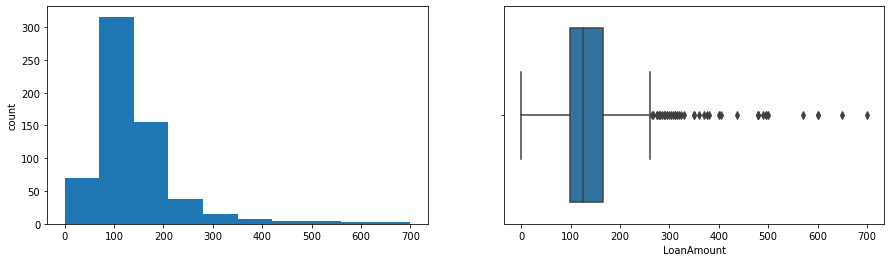

total_income
Skew : 5.63


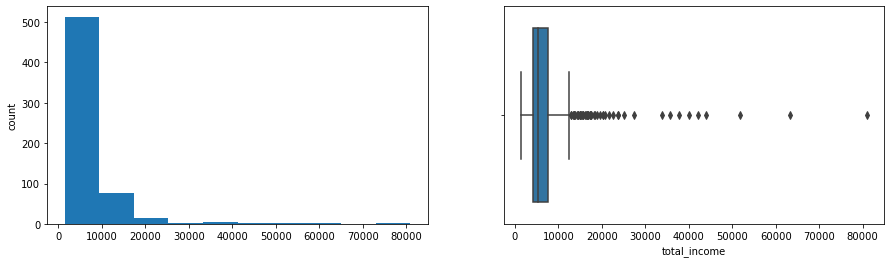

In [27]:
#### Check the distribution and outliers for each column in the data
for col in ['LoanAmount', 'total_income']:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

## **Checking the percentage of each category for categorical variables**

In [28]:
#Creating list of categorical columns
cat_col= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area', 'Loan_Status']

for col in cat_col:
    print(data[col].value_counts(normalize=True))  #The parameter normalize=True gives the percentage of each category
    print('*'*40)                                  

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64
****************************************
Yes    0.651391
No     0.348609
Name: Married, dtype: float64
****************************************
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64
****************************************
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
****************************************
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64
****************************************
1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64
****************************************
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
****************************************
1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64
****************************************


**Observations:**

- Percentage of male customers (approx 81%) is more than the percentage of female customers (approx 19%).
- About 65% of customers are married. This indicates that married people apply more for the home loan as compared to non-married people.
- The majority of customers have 0 or 1 dependents. Some of these entries are 3+ which means 3 or more dependents. Since we don't know the actual number, we can treat this as a separate category.
- About 78% of customers are graduate. It looks like the majority of customers are educated.
- Only ~14% of customers are self-employed. This indicates that salaried people apply more for the home loan.
- The majority of customers, about 84%, have credit history as per the required guidelines.
- The count of observations is approximately evenly distributed among Urban, Semi-Urban, and Rural areas. This implies that the company has a presence in all kinds of areas.
- The number of home loans approved is comparatively higher than the number of those not approved. About 69% of applied loans get approved. Although we have limited data, the reason for this could either be a fairly lenient attitude from the company towards approving loans OR that many of the customers applying for these home loans are actually eligible for them.

#### Imputing missing values

In [29]:
#Imputing missing values with mode for the categorical variables 
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    data[col].fillna(value=data[col].mode()[0], inplace=True)

In [30]:
#Replacing 0's with null values in loan amount 
data.LoanAmount.replace(0, np.nan, inplace=True)

#Imputing null values in loan amount with the median
data.LoanAmount.fillna(value=data.LoanAmount.median(), inplace=True)

# Bivariate Analysis
**Let's check the relationship of loan amount with the total income.**

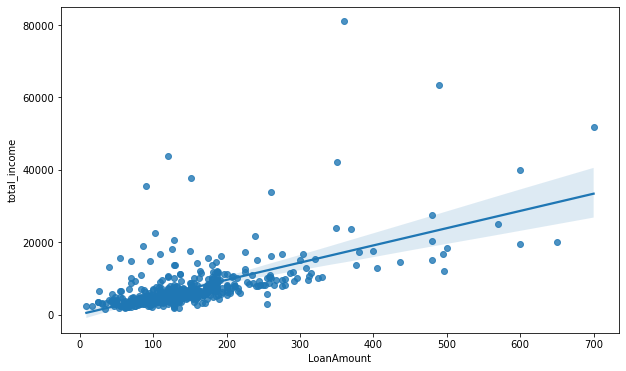

In [31]:
plt.figure(figsize=(10,6))
sns.regplot(x='LoanAmount', y='total_income', data=data)
plt.show()

**Observations:**
- The plot shows that the loan amount is positively correlated with total income. This implies that the loan amount for higher-income applicants is progressively higher.
- There are some outliers visible, showing applicants with low income having been given loans of a higher amount.

**Let's check the relationship of total income with loan status**

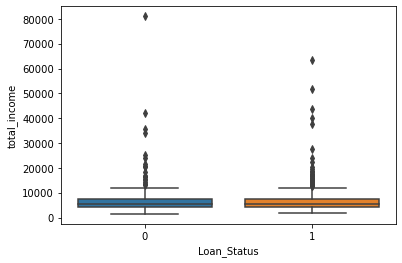

In [32]:
sns.boxplot(x=data.Loan_Status, y=data.total_income)

**Observations:**
- Except for some outliers, there is no major difference between the income of those customers who are eligible versus those who are not. 
- This implies that income alone might not be a good indicator of a customer's loan eligibility.

** Let's check how credit history is related to loan status **

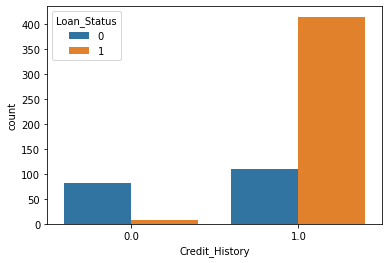

In [33]:
sns.countplot(x=data.Credit_History, hue=data.Loan_Status)

**Observations:**
- The plot shows that credit history is an important factor while checking loan eligibility. There are very few customers whose loan was approved even when their credit history did not meet required guidelines.

**Let's check the relationship between education and loan status**

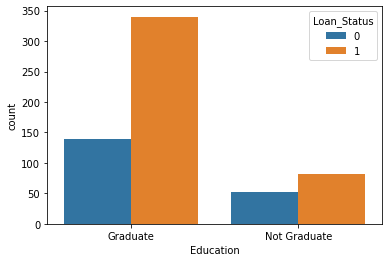

In [34]:
sns.countplot(x=data.Education, hue=data.Loan_Status)

**Observations:**
- We can see that graduate customers are more likely to get loans.
- This might be because, in general, graduate customers have higher income when compared to non-graduates. Let's check if this is true.

**Let's check the relationship between education and total income**

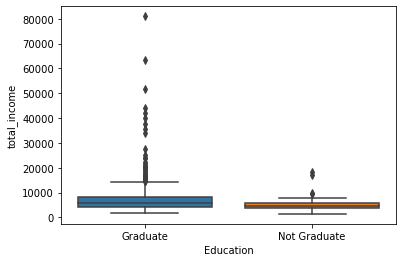

In [36]:
sns.boxplot(x=data.Education, y=data.total_income)

**Observations:**
- We can see that this does appear to be true; graduate customers seem to earn more on average.

**Let's check how property area is related with loan status**

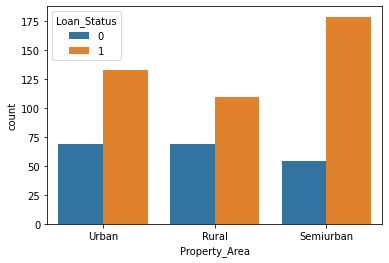

In [64]:
sns.countplot(x=data.Property_Area, hue=data.Loan_Status)

**Observations:**

- The plot shows that more loans are approved for properties in semi-urban areas. 
- This could be due to several reasons. The bank might be charging higher interest rates for semi-urban areas or the current customer base of the company from semi-urban areas might actually be more eligible for home loans based on loan applicant features. We cannot be certain as we don't have the data to support this claim.

**Now that we have processed and explored our data, let's prepare it for modeling.**

#### Preparing data for modeling

In [37]:
#Separating target variable and other variables
X=data.drop(columns='Loan_Status')
Y=data['Loan_Status']

In [38]:
#Creating dummy variables 
#drop_first=True is used to avoid redundant variables
X = pd.get_dummies(X, drop_first=True)

In [43]:
#Splitting the data into train and test sets
x_train,x_test,y_train,y_test=train_test_split(X, Y, test_size=0.30, random_state=7)

Now, we are done with the data preprocessing. Let's move to the model building section.

## **Building Classification Models**

**Before training the model, let's choose the appropriate model evaluation criterion as per the problem on hand.**

### Model evaluation criterion:

#### Since this is a binary classification problem, the model can make wrong predictions in one of two ways:
1. Predicting a customer is not eligible for a loan when the customer actually is eligible - **Loss of opportunity**
2. Predicting a customer is eligible for a loan when the customer is actually not - **Financial Loss**

#### Which case is more important? 
* **Predicting that the customer is eligible when he is not**, because the person might default or not be able to return the loan, which would result in financial loss to the company.

#### How to reduce this loss i.e need to reduce False Negatives?
* In classification, the class of interest is considered the positive class. Here, the class of interest is 0 i.e. identifying non-eligible customers. So, the company wants to minimize the number of false negatives, in other words **Recall** is the evaluation criterion to be maximized.

#### let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.

In [40]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

 **Linear Discriminant Analysis (LDA)**
 Linear discriminant analysis (LDA) is generally used to classify patterns between two classes; however, it can be extended to classify multiple patterns. LDA assumes that all classes are linearly separable and according to this, multiple linear discrimination functions representing several hyperplanes in the feature space are created to distinguish between the classes. If there are two classes, then the LDA draws one hyperplane and projects the data onto this hyperplane in such a way as to maximize the separation of the two categories. This hyperplane is created according to two criteria considered simultaneously:

- Maximizing the distance between the means of two classes;
- Minimizing the variation between each category.

In [44]:
#fitting lda model
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

LinearDiscriminantAnalysis()

              precision    recall  f1-score   support

           0       0.92      0.41      0.57       131
           1       0.79      0.98      0.88       298

    accuracy                           0.81       429
   macro avg       0.85      0.70      0.72       429
weighted avg       0.83      0.81      0.78       429



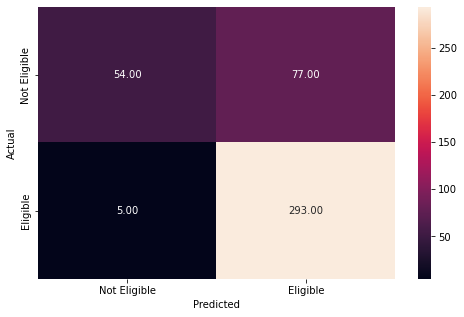

In [45]:
#checking model performance of lda
y_pred_train_lda = lda.predict(x_train)
metrics_score(y_train, y_pred_train_lda)

In [47]:
#creating list of column names
cols=X.columns

#saving coefficients of lda model
coef_lda=lda.coef_

#printing the cofficients of lda
pd.DataFrame(coef_lda,columns=cols).T.sort_values(by=0,ascending=False)

,0
Credit_History,4.823615
Married_Yes,0.751970
Property_Area_Semiurban,0.742081
Dependents_2,0.452345
Dependents_3+,0.427453
Self_Employed_Yes,0.191595
Property_Area_Urban,0.146022
total_income,-0.000031
LoanAmount,-0.000989
Loan_Amount_Term,-0.007488


####  Precision-Recall Curve for LDA

**Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.**


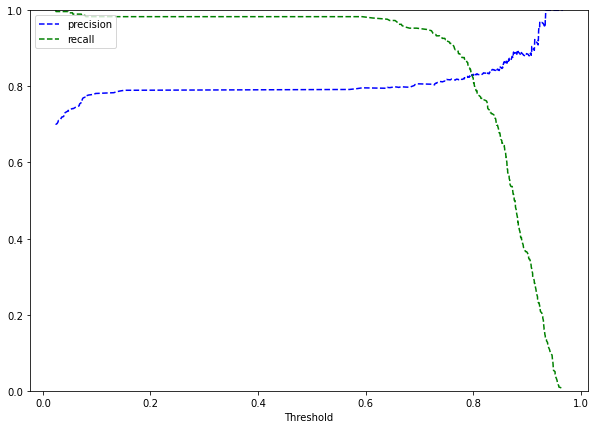

In [48]:
y_scores_lda=lda.predict_proba(x_train) #predict_proba gives the probability of each observation belonging to each class


precisions_lda, recalls_lda, thresholds_lda = precision_recall_curve(y_train, y_scores_lda[:,1])

#Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds_lda, precisions_lda[:-1], 'b--', label='precision')
plt.plot(thresholds_lda, recalls_lda[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.41      0.57       131
           1       0.79      0.98      0.88       298

    accuracy                           0.81       429
   macro avg       0.85      0.70      0.72       429
weighted avg       0.83      0.81      0.78       429



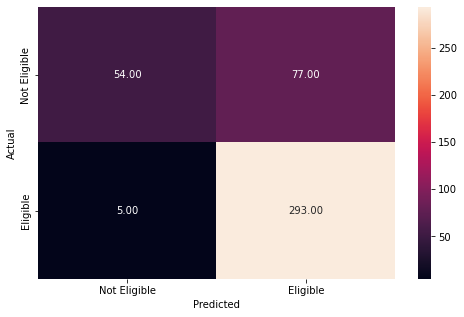

In [58]:
optimal_threshold1=.35
y_pred_train_lda = lda.predict_proba(x_train)
metrics_score(y_train, y_pred_train_lda[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.93      0.46      0.62        61
           1       0.79      0.98      0.87       124

    accuracy                           0.81       185
   macro avg       0.86      0.72      0.74       185
weighted avg       0.84      0.81      0.79       185



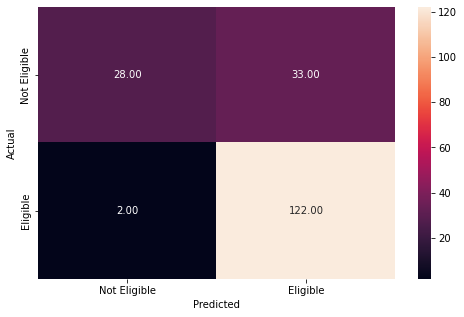

In [59]:
optimal_threshold1=.35
y_pred_test_lda = lda.predict_proba(x_test)
metrics_score(y_test, y_pred_test_lda[:,1]>optimal_threshold1)

### Quadratic Discriminant Analysis
Quadratic discriminant analysis (QDA) is a probabilistic parametric classification technique which represents an evolution of LDA for nonlinear class separations. QDA, like LDA, is based on the hypothesis that the probability density distributions are multivariate normal but, in this case, the dispersion is not the same for all of the categories.


In [60]:
#fitting qda model
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)

QuadraticDiscriminantAnalysis()

              precision    recall  f1-score   support

           0       0.84      0.45      0.59       131
           1       0.80      0.96      0.87       298

    accuracy                           0.81       429
   macro avg       0.82      0.71      0.73       429
weighted avg       0.81      0.81      0.79       429



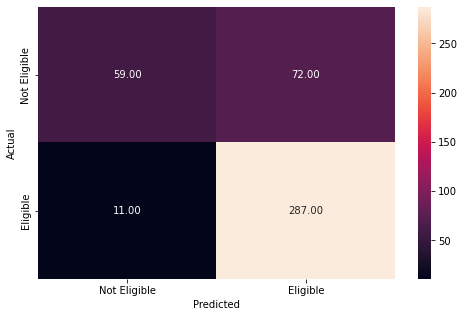

In [61]:
#checking model performance on the training data
y_pred_train_qda = qda.predict(x_train)
metrics_score(y_train, y_pred_train_qda)

**Let's move on to another model - Logistic Regression

### Logistic Regression

In [62]:
log_reg= LogisticRegression(random_state=1)

log_reg.fit(x_train,y_train)

LogisticRegression(random_state=1)

In [63]:
pd.Series(log_reg.coef_[0], index=x_train.columns).sort_values(ascending=False)

Credit_History             3.006569
Property_Area_Semiurban    0.725591
Married_Yes                0.425012
Dependents_2               0.394610
Self_Employed_Yes          0.084766
total_income              -0.000035
LoanAmount                -0.000569
Property_Area_Urban       -0.008981
Dependents_3+             -0.033317
Loan_Amount_Term          -0.061075
Gender_Male               -0.216884
Dependents_1              -0.246658
Education_Not Graduate    -0.537382
dtype: float64

**Observations:

- The attribute Credit history stands out among all the features which is fairly reasonable to imply that loan applicants with good credit history are likely get approved for loan.
- The features Property Area_Semi Urban, Married, Dependents_2, Dependents_3 also seem to positively affect the Loan approval rate.It might be that applicants situated in Semiurban areas satisfy the credit history and other loan requirements and are more likely to get approved.
- Education_Not Graduate seem to be negatively affecting the Loan approval rate which indicates that applicants who are not graduates are less likely to get approved.
- The remaining features have very low coefficients and does not seem to drive the loan approval as much.


**

In [65]:
odds = np.exp(log_reg.coef_[0]) #finding the odds

#adding the odds to a dataframe and sorting the values
pd.DataFrame(odds, x_train.columns, columns=['odds']).sort_values(by='odds', ascending=False) 

,odds
Credit_History,20.217922
Property_Area_Semiurban,2.065952
Married_Yes,1.529608
Dependents_2,1.483805
Self_Employed_Yes,1.088462
total_income,0.999965
LoanAmount,0.999432
Property_Area_Urban,0.991059
Dependents_3+,0.967232
Loan_Amount_Term,0.940753


**Observations:

- The odds of getting a loan approval is much higher if the applicant has a good Credit history.This suggests that Credit history is a very good predictor of whether the loan gets approved or not.
- The odds of applicant with 2 or more dependents getting loan approval is almost double than those with only one dependent.
- For applicants owning properties in Semiurban areas, the odds of getting approved for loan is much higher than those in urban and rural areas.
- The marital status- Married is also a good predictor of whether the loan gets accepted or rejected. We can see that for married applicants, the odds of getting approved is 1.2 times higher than for those with other marital status.   

**

**Now, let's check the performance of the model on the training set**

              precision    recall  f1-score   support

           0       0.89      0.42      0.57       131
           1       0.79      0.98      0.88       298

    accuracy                           0.81       429
   macro avg       0.84      0.70      0.72       429
weighted avg       0.82      0.81      0.78       429



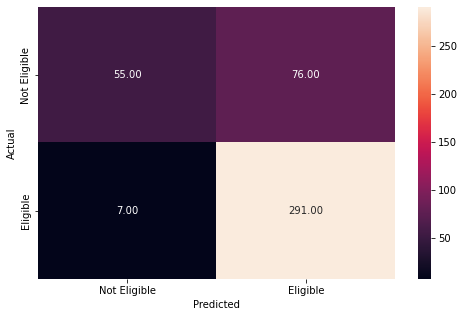

In [66]:
#predict on the training data 
y_pred_train = log_reg.predict(x_train)

# Checking performance on the training data
metrics_score(y_train, y_pred_train)

**Observations:

- We can see in the classification report that there is 81% accuracy on the training dataset.
- However the recall is only about 42% for class of interest which indicates that the model performance would not be as good in differentiating those applicants who are more likely to default.
- We can see from the confusion matrix that the values of False negatives(73) is too high which means this model fails to identify the applicants who are more likely to default or at risk. 

**

**Precision-Recall Curve for Logistic Regression**

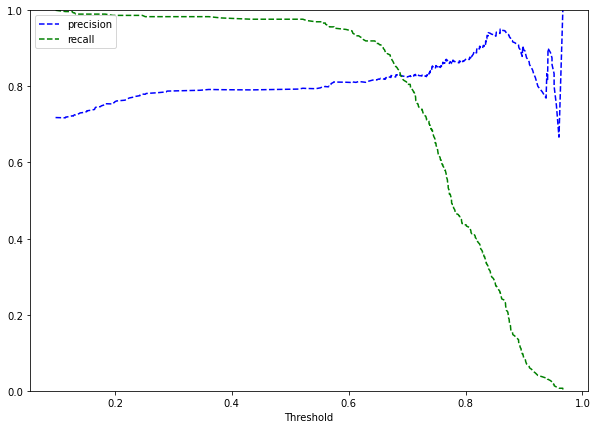

In [67]:
y_scores=log_reg.predict_proba(x_train) #predict_proba gives the probability of each observation belonging to each class


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

#Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

**Observations:**
- We can see that precision and recall are balanced for threshold of about 0.7.
- Let's try to calculate the exact threshold where precision and recall are equal.

In [68]:
#calculating the exact threshold where precision and recall are equal.
for i in np.arange(len(thresholds)):
    if precisions[i]==recalls[i]:
        print(thresholds[i])

0.6883198225148315


- The threshold of 0.75 would give a balanced precision and recall.
- We can choose the threshold to be a bit higher to make the recall higher but then the precision would drop.
- **This decision depends on the stakeholders and other business driven factors.** For example, if the company can bear the cost of some false positives and be more conservative while approving loans then we can choose for the recall to be higher.
- Let's choose the recall to be 0.75 for the current scenario, since we have mentioned that the company wants to optimize recall.
- **Note:** We also don't want the precision to be so poor that it outweighs the benefits of a higher recall. 

              precision    recall  f1-score   support

           0       0.48      0.75      0.58       131
           1       0.85      0.64      0.73       298

    accuracy                           0.67       429
   macro avg       0.67      0.69      0.66       429
weighted avg       0.74      0.67      0.69       429



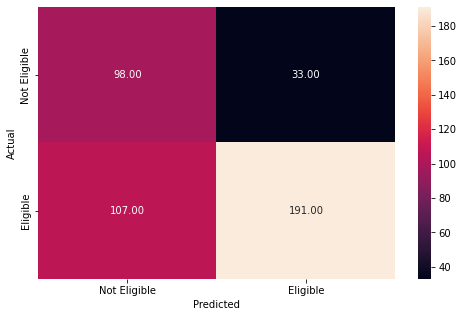

In [74]:
optimal_threshold1 = 0.75
metrics_score(y_train, y_scores[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.50      0.72      0.59        61
           1       0.82      0.65      0.72       124

    accuracy                           0.67       185
   macro avg       0.66      0.68      0.66       185
weighted avg       0.72      0.67      0.68       185



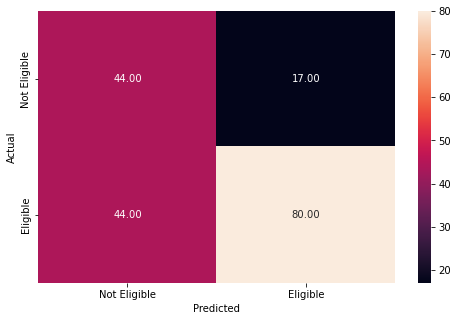

In [75]:
#Checking performance on the testing data
y_pred_test = log_reg.predict_proba(x_test)
metrics_score(y_test, y_pred_test[:,1]>optimal_threshold1)

**Observations:

- After adjusting for the threshold, the accuracy of the model goes down, but the recall improves significantly.There is definitely a trade-off between precision and recall, but since we are more interested in optimizing the recall, we can ignore the trade-off here.
- This model also minimizes the False negatives i.e predicting the applicant is eligible when he is actually not which in turn helps minimize the Financial losses.
- Additionally, the f1-score of 0.58 for train and the test set favors the Logistic Regression after tuning in the threshhold.
- The overall model performance is better than before adjusting for the threshhold.
- Let us check out the model performance with other algorithms.

**

### K - Nearest Neighbors (KNN)

- KNN is a distance based algorithm and all distance based algorithms are affected by the scale of the data.
- We will scale the attributes (dataframe X defined above) before building the KNN model.

**But before actually building the model, we need to identify the value of K to be used in KNN. We will perform the following steps for the same.**

- For every value of K (from 1 to 20), split the train set into new train and validation set (30 times)
- Scale the training data and validation data
- Take the average of the error on these train and the validation sets for each K
- Plot the average train vs the validation set error for all Ks 
- Choose a suitable K from the plot where the two errors are comparable

In [87]:
knn = KNeighborsClassifier()
ss = StandardScaler()

# We select the best value of k for which the error rate is the least in the validation data
# Let us loop over a few values of the k to determine the best k

train_error = []
test_error = []
knn_many_split = {}

error_df_knn = pd.DataFrame()
features = X.columns

for k in range(1,21):
    train_error = []
    test_error = []
    lista = []
    knn = KNeighborsClassifier(n_neighbors=k)
    for i in range(30):
        x_train_new, x_val, y_train_new, y_val = train_test_split(x_train, y_train, test_size = 0.20)
    
        #let us scale the data
        x_train_new = ss.fit_transform(x_train_new)  #fit_transform the training data
        x_val = ss.transform(x_val) #transform the validation set
        #Fitting knn on training data
        knn.fit(x_train_new, y_train_new)
        #Calculating error on training and validation data
        train_error.append(1 - knn.score(x_train_new, y_train_new)) 
        test_error.append(1 - knn.score(x_val, y_val))
    lista.append(sum(train_error)/len(train_error))
    lista.append(sum(test_error)/len(test_error))
    knn_many_split[k] = lista

knn_many_split

{1: [0.0, 0.3027131782945735],
 2: [0.13148688046647228, 0.37170542635658915],
 3: [0.1678328474246841, 0.26472868217054263],
 4: [0.17998056365403298, 0.3104651162790697],
 5: [0.1949465500485909, 0.23682170542635664],
 6: [0.19232264334305157, 0.24573643410852714],
 7: [0.20835762876579203, 0.2306201550387597],
 8: [0.19883381924198254, 0.23410852713178296],
 9: [0.20670553935860062, 0.2414728682170542],
 10: [0.20524781341107876, 0.22751937984496126],
 11: [0.21311953352769686, 0.22403100775193802],
 12: [0.2043731778425656, 0.22286821705426357],
 13: [0.21904761904761907, 0.21860465116279065],
 14: [0.2132167152575316, 0.1972868217054264],
 15: [0.21895043731778427, 0.23953488372093018],
 16: [0.21224489795918372, 0.22480620155038764],
 17: [0.22079689018464535, 0.23255813953488377],
 18: [0.20952380952380956, 0.24302325581395348],
 19: [0.21972789115646257, 0.24302325581395348],
 20: [0.21418853255587955, 0.22635658914728693]}

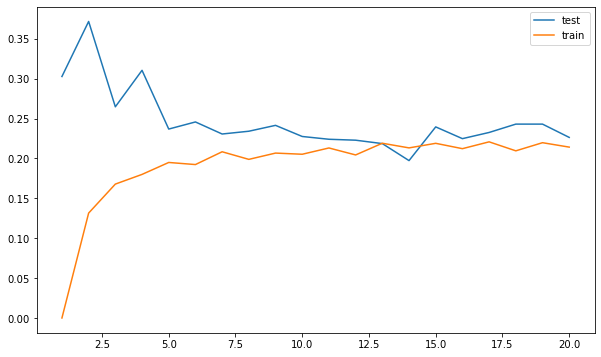

In [88]:
# Extracting the train and the test error for each k in a list for easy plotting

kltest = []
vltest = []
for k, v in knn_many_split.items():
    kltest.append(k)
    vltest.append(knn_many_split[k][1])

kltrain = []
vltrain = []

for k, v in knn_many_split.items():
    kltrain.append(k)
    vltrain.append(knn_many_split[k][0])

# Plotting k vs error 
plt.figure(figsize=(10,6))
plt.plot(kltest,vltest, label = 'test' )
plt.plot(kltrain,vltrain, label = 'train')
plt.legend()
plt.show()

**Observations:**
- We can see that the train error and the test error are more or less similar for K more than or equal to 8.
- This implies that we would get generalized results if we choose K=8.
- So, let's scale the full data and fit the model on the entire training set. 

In [90]:
# scaling the data
scaler=StandardScaler()
x_train_scaled=pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)  #fit_transform the training data
x_test_scaled=pd.DataFrame(scaler.transform(x_test), columns=x_test.columns) #transform the testing data

In [112]:
#Fitting the model on the scaled data
knn = KNeighborsClassifier(n_neighbors = 8, weights='distance')
knn.fit(x_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=8, weights='distance')

**Now, let's check the performance of the model on the training and testing data**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



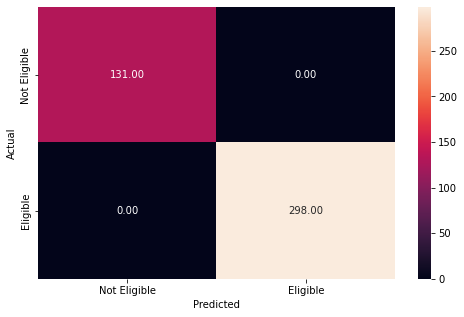

In [113]:
#predict on train data
y_pred_train_knn =knn.predict(x_train_scaled)

#checking performance of the model
metrics_score(y_train, y_pred_train_knn)

**Observations:

- KNN model seems to be overfitting on the training dataset. Let us check the performance on the test set.

**

              precision    recall  f1-score   support

           0       0.78      0.48      0.59        61
           1       0.78      0.94      0.85       124

    accuracy                           0.78       185
   macro avg       0.78      0.71      0.72       185
weighted avg       0.78      0.78      0.77       185



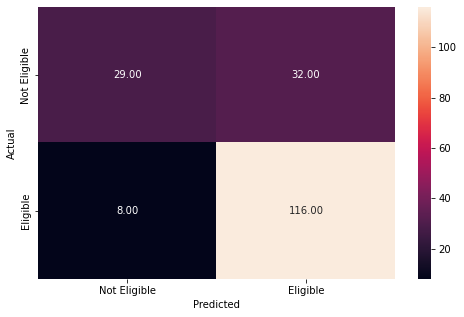

In [114]:
#predict on test data
y_pred_test_knn = knn.predict(x_test_scaled)

#checking performance of the model
metrics_score(y_test, y_pred_test_knn)

**Observation:

- Here the accuracy of the model is about 78% but the recall is only 0.48% for the class of interest.This will not help the bank in identifying the applicants at risk in an efficient manner.
- We can see from the confusion matrix that the model fails to identify a large number of applicants who might default and lead to financial losses.
- Examining the Logistic regression and KNN algorithms closely, the Logistic regression after adjusting the threshold seems to perform really well with a better f1-score and better recall.
- Logistic Regression is able to minimize the Credit risk better than the KNN. 

**

## **Decision Tree**

In this section, we will implement a decision tree classifier on the data.


In [129]:
#Fitting the decision tree classifier on the training data
d_tree = DecisionTreeClassifier(random_state=7) 

d_tree.fit(x_train,y_train)

DecisionTreeClassifier(random_state=7)

**Let's check the performance on the training data:**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



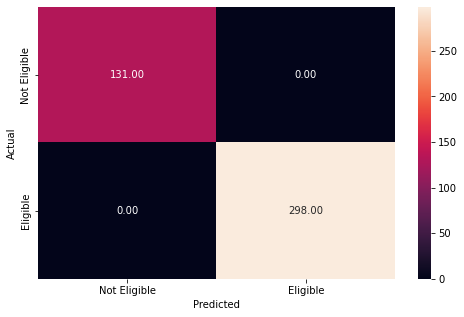

In [130]:
#Checking performance on the training data
y_pred_train1 = d_tree.predict(x_train)
metrics_score(y_train,y_pred_train1)

**Observations:
- The Decision Tree is giving us a 100% result on the training dataset.

**

**Let's check the performance of the model on the testing data:**

              precision    recall  f1-score   support

           0       0.65      0.54      0.59        61
           1       0.79      0.85      0.82       124

    accuracy                           0.75       185
   macro avg       0.72      0.70      0.71       185
weighted avg       0.74      0.75      0.75       185



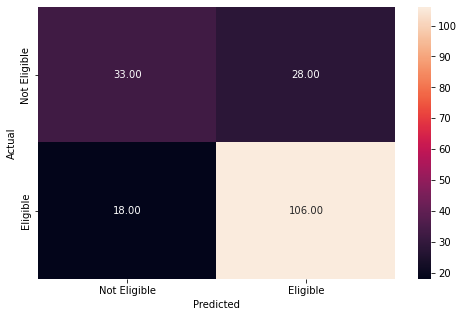

In [131]:
#Checking performance on the testing data
y_pred_test1 = d_tree.predict(x_test)
metrics_score(y_test,y_pred_test1 )

**Observations:

- The Decision tree performs really well on the training set where as it does not perform well on the test set since the recall for class 0 on the test set is 0.54 as compared to 1 on the training set.   The metric scores indicate that the model overfits on the training data.
- The precision of 0.65 estimates that the bank is able to correctly identify the non eligible customers only 65% of the time which is a huge loss in terms of financial losses since there will be large number of customers defaulting because this model will predict eligibility for those customers when they were actually not.  

**

**Let's try hyperparameter tuning using GridSearchCV to find the optimal max_depth** in order to reduce overfitting of the model. We can tune some other hyperparameters as well.

## **Decision Tree - Hyperparameter Tuning**

We will use the class_weight hyperparameter with value equal to {0:0.7, 1:0.3} which is approximately the opposite of the imbalance in the original data. 

**This would tell the model that 0 is the important class here.**

In [132]:
# Choose the type of classifier 
d_tree_tuned = DecisionTreeClassifier(random_state=7, class_weight={0:0.7, 1:0.3})

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,10), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations - recall score for class 0
scorer = metrics.make_scorer(recall_score, pos_label=0)

# Run the grid search
grid_obj = GridSearchCV(d_tree_tuned, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
d_tree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data 
d_tree_tuned.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.7, 1: 0.3}, criterion='entropy',
                       max_depth=7, min_samples_leaf=20, random_state=7)

We have tuned the model and fit the tuned model on the training data. Now, **let's check the model performance on the training and testing data.**

              precision    recall  f1-score   support

           0       0.57      0.79      0.66       131
           1       0.89      0.74      0.81       298

    accuracy                           0.75       429
   macro avg       0.73      0.76      0.73       429
weighted avg       0.79      0.75      0.76       429



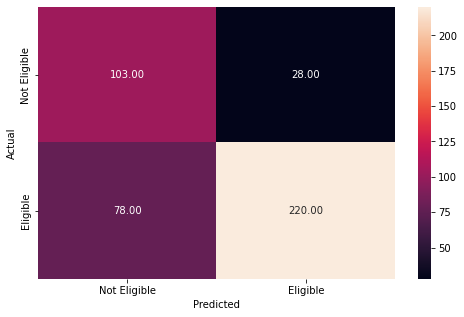

In [133]:
#Checking performance on the training data
y_pred_train2 = d_tree_tuned.predict(x_train)
metrics_score(y_train,y_pred_train2)

**Let's check the model performance on the testing data**

              precision    recall  f1-score   support

           0       0.51      0.61      0.56        61
           1       0.79      0.72      0.75       124

    accuracy                           0.68       185
   macro avg       0.65      0.66      0.65       185
weighted avg       0.70      0.68      0.69       185



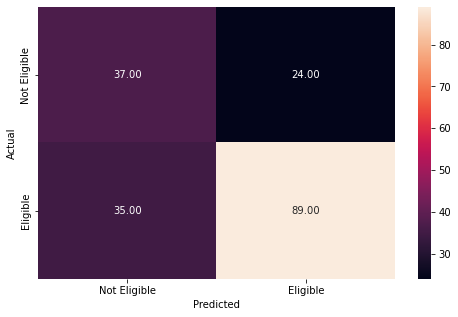

In [134]:
#Checking performance on the testing data
y_pred_test2 = d_tree_tuned.predict(x_test)
metrics_score(y_test,y_pred_test2)

**Observations:

- After tuning in, there is a significant improvement in recall from our previous model performance on the testing set.The tuned model gives a better recall (0.61).
- The precision and accuracy of the tuned model is lower than our base model.Only 51% of the times, the bank will be able to corectly classify the customers as non elligible which is not as efficient since this model will predict more number of false positives.


**

**Let's visualize the tuned decision tree** and observe the decision rules:

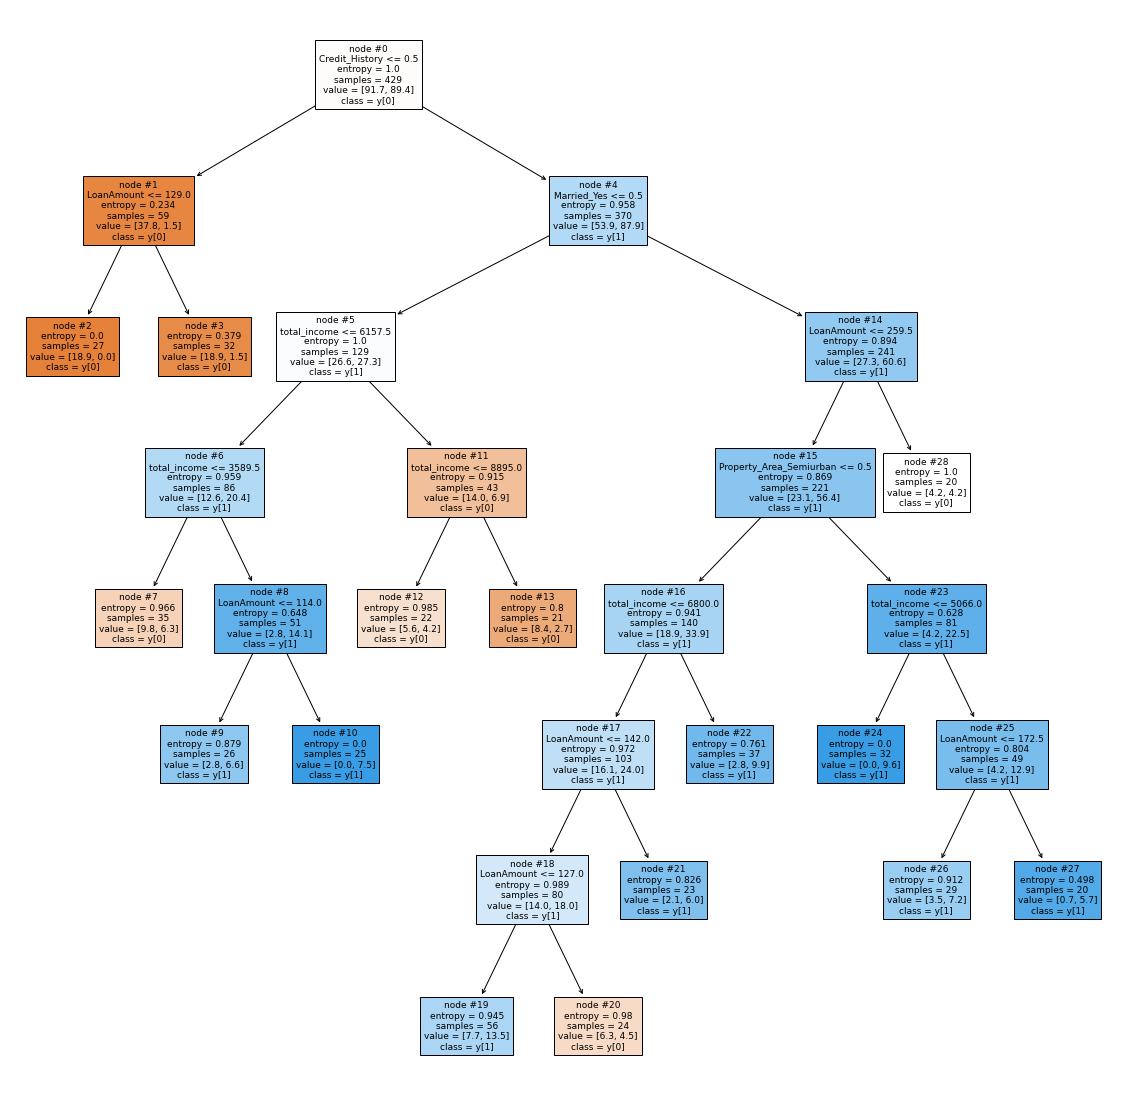

In [135]:
features = list(X.columns)

plt.figure(figsize=(20,20))

tree.plot_tree(d_tree_tuned,feature_names=features,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

**Let's look at the feature importance** of the tuned decision tree model:

In [136]:
# Importance of features in the tree building

print (pd.DataFrame(d_tree_tuned.feature_importances_, columns = ["Imp"], index = x_train.columns).sort_values(by = 'Imp', ascending = False))

                              Imp
Credit_History           0.574778
total_income             0.206104
LoanAmount               0.122203
Married_Yes              0.054235
Property_Area_Semiurban  0.042681
Loan_Amount_Term         0.000000
Gender_Male              0.000000
Dependents_1             0.000000
Dependents_2             0.000000
Dependents_3+            0.000000
Education_Not Graduate   0.000000
Self_Employed_Yes        0.000000
Property_Area_Urban      0.000000


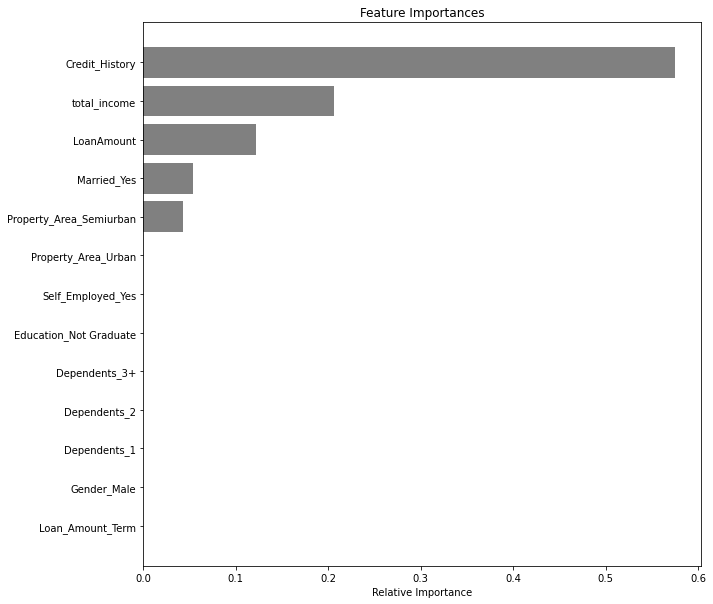

In [138]:
#Plotting the feature importance
importances = d_tree_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='grey', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Observations:**
- **Credit history is the most important feature** **followed by total income and loan amount** which makes sense.
- **Married_Yes and Property_Area_Semiurban have some importance** and the rest of the variables have no impact in this model, while deciding loan eligibility.

Now let's build another model - **a random forest classifier**

## **Random Forest Classifier**

In [139]:
#Fitting the decision tree classifier on the training data
rf_estimator = RandomForestClassifier(random_state=7)
rf_estimator.fit(x_train,y_train)

RandomForestClassifier(random_state=7)

**Let's check the performance of the model on the training data:**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



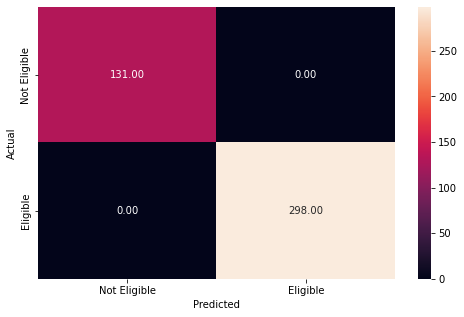

In [140]:
#Checking performance on the training data
y_pred_train3 = rf_estimator.predict(x_train)
metrics_score(y_train, y_pred_train3)

**Observations:

-  The Random Forest is giving a 100% result on the training dataset which means the model overfits the training set.

**

**Let's confirm this by checking its performance on the testing data:**

              precision    recall  f1-score   support

           0       0.81      0.49      0.61        61
           1       0.79      0.94      0.86       124

    accuracy                           0.79       185
   macro avg       0.80      0.72      0.74       185
weighted avg       0.80      0.79      0.78       185



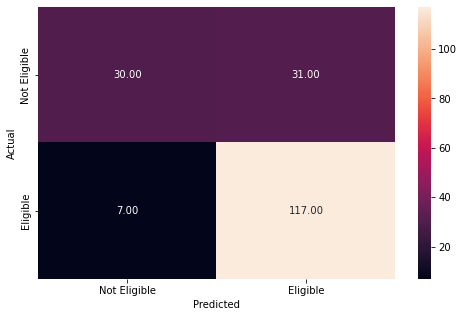

In [45]:
#Checking performance on the testing data
y_pred_test3 = rf_estimator.predict(X_test)
metrics_score(y_test, y_pred_test3)

**Observations:

- The recall for RF classifier on the testing dataset is only 0.49 which is not very efficient, hence this model does not perform well on the testing set where as the model overfits the training set.
- Precision on the testing set using Random Forest is very good.

**

 **Let's see if we can get a better model by tuning the random forest classifier:**

## **Random Forest Classifier - Hyperparameter Tuning**

Let's try **tuning some of the important hyperparameters of the Random Forest Classifier**. 

We will **not** tune the `criterion` hyperparameter as we know from hyperparameter tuning for decision trees that `entropy` is a better splitting criterion for this data.

In [141]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(criterion="entropy", random_state=7)

# Grid of parameters to choose from
parameters = {"n_estimators": [100, 110, 120],
    "max_depth": [5, 6, 7],
    "max_features": [0.8, 0.9, 1]
             }

# Type of scoring used to compare parameter combinations - recall score for class 0
scorer = metrics.make_scorer(recall_score, pos_label=0)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

In [142]:
#Fitting the best algorithm to the training data
rf_estimator_tuned.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features=0.9,
                       n_estimators=110, random_state=7)

              precision    recall  f1-score   support

           0       0.98      0.48      0.65       131
           1       0.81      1.00      0.90       298

    accuracy                           0.84       429
   macro avg       0.90      0.74      0.77       429
weighted avg       0.87      0.84      0.82       429



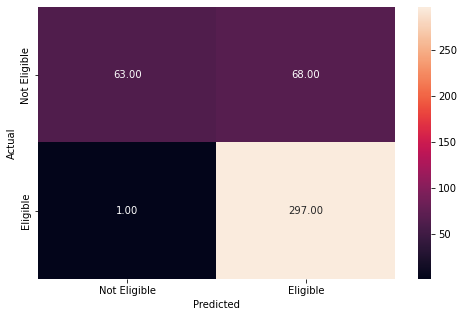

In [143]:
#Checking performance on the training data
y_pred_train4 = rf_estimator_tuned.predict(x_train)
metrics_score(y_train, y_pred_train4)

**Observations:**
- We can see that after hyperparameter tuning, the model is performing poorly on the train data as well.
- We can try adding some other hyperparameters and/or changing values of some hyperparameters to tune the model and see if we can get a better performance.


In [145]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(criterion="entropy", random_state=7)

# Grid of parameters to choose from
parameters = {"n_estimators": [110, 120],
    "max_depth": [6, 7],
    "min_samples_leaf": [20, 25],
    "max_features": [0.8, 0.9],
    "max_samples": [0.9, 1],
    "class_weight": [{0:0.7, 1:0.3}, "balanced", {0:0.4, 1:0.1}]
             }

# Type of scoring used to compare parameter combinations - recall score for class 0
scorer = metrics.make_scorer(recall_score, pos_label=0)

# Run the grid search on the training data using scorer=scorer and cv=5
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(x_train, y_train)
# Save the best estimator to variable rf_estimator_tuned
rf_estimator_tuned = grid_obj.best_estimator_

#Fit the best estimator to the training data
rf_estimator_tuned.fit(x_train,y_train)

RandomForestClassifier(class_weight={0: 0.4, 1: 0.1}, criterion='entropy',
                       max_depth=6, max_features=0.8, max_samples=0.9,
                       min_samples_leaf=25, n_estimators=120, random_state=7)

**Let's check the performance of the tuned model:**

              precision    recall  f1-score   support

           0       0.52      0.85      0.65       131
           1       0.91      0.65      0.76       298

    accuracy                           0.71       429
   macro avg       0.71      0.75      0.70       429
weighted avg       0.79      0.71      0.72       429



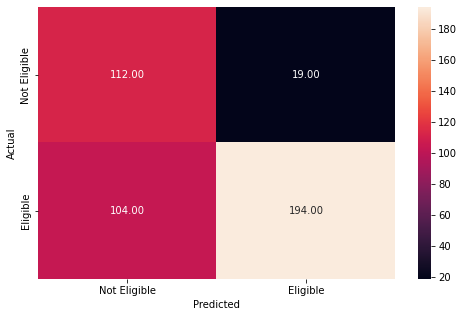

In [147]:
#Checking performance on the training data
y_pred_train5 = rf_estimator_tuned.predict(x_train)
metrics_score(y_train, y_pred_train5)

**Observations:

- The recall on the training data after tuning the model is quite good(0.85). 
- The precision is only 0.52 on the training data.

**

**Let's check the model performance on the test data:**

              precision    recall  f1-score   support

           0       0.50      0.70      0.59        61
           1       0.82      0.65      0.73       124

    accuracy                           0.67       185
   macro avg       0.66      0.68      0.66       185
weighted avg       0.71      0.67      0.68       185



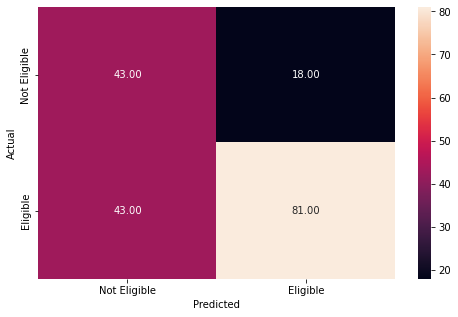

In [148]:
#Checking performance on the testing data
y_pred_test5 =rf_estimator_tuned.predict(x_test)
metrics_score(y_test, y_pred_test5)

**Observations:

- The tuned RF model performs well on the testing data.
- Although, the precision is quite low, here we are more interested in minimizing the False negatives i.e maximizing the recall. The recall significantly improved from 0.49 to 0.70 on the testing data.
- There is definitely a trade-off between precision and recall here which the bank might need to play close attention to if any predictions are made based on this model.

**

**One of the drawbacks of ensemble models is that we lose the ability to obtain an interpretation of the model. We cannot observe the decision rules for random forests the way we did for decision trees. So, let's just check the feature importances of the model.**

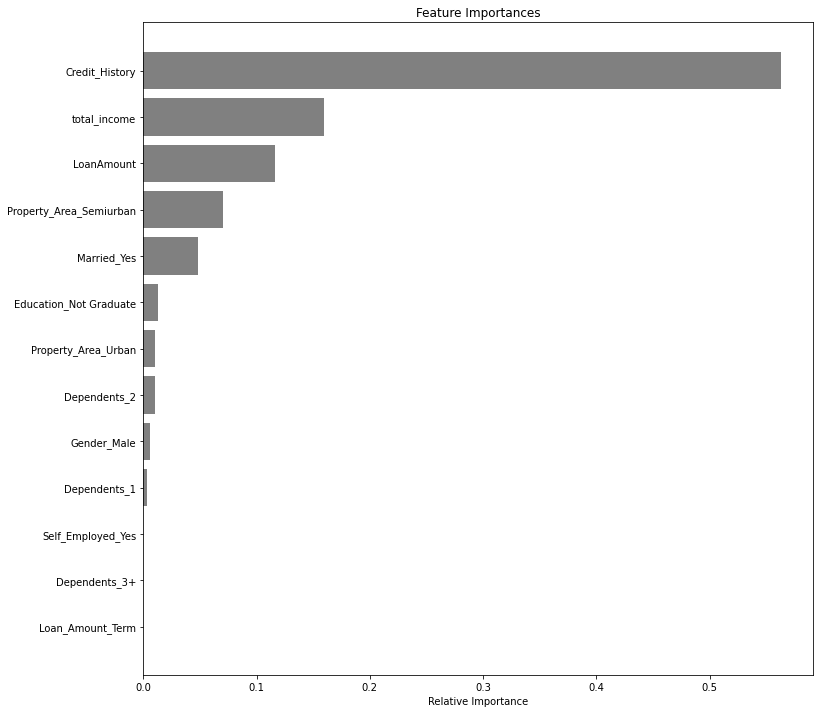

In [150]:
importances = rf_estimator_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='grey', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Observations:

- The feature importance plot for RF Classifier gives a better overview of the features that are more influential on the loan eligibility. 
- The most important features that drives the eligibility decision are Credit History followed by total income, Loan amount, Property Area-Semiurban and Married-yes.
- Other features like Education-Not Graduate, Property Area-Urban, Dependent-2 ,Gender-Male and Dependent-1 have very little impact on the decision.

**

## **Conclusion and Recommendations**

**Conclusions:

- We have seen that **tuned Random Forest model does better in terms of recall on training and testing datasets.** The recall on training is ~0.85 and on testing is ~0.70 which is much better than the Decision tree and   base RF model..
- Although the precision is quite low in both training(~ 0.52) and testing sets(~ 0.50), the bank needs to make a decision if they are willing to slip of the False positives inorder to maximize the recall.
- Throughout our analysis, we have seen that **Credit history,total amount, loan amount, Property Area_Semiurban and Married-Yes are the most influential attributes in loan eligibility decision.** 

**

**Recommendations:

- Since **Credit History is the most important feature of Loan eligibility,** the bank should focus on the customer base with good credit history inorder to minimize the default loans.
- We also saw that total income, loan amount,Property area-Semiurban and Married-Yes are also some of the very important attributes in the loan approval process which does make sense since customers who are married,   have higher income and own properties in Semi urban areas mostly come with a good credit history. This is the type of customer base that the bank should focus on in-oder to have most loan amount payed on a timely basis.
- The bank should offer some incentives for customers falling into this category which could lead the bank to have a strong relationship and overall good customer base.The small incentives and good customer service provided to this group might help the bank make more business with great returns and minimize credit risk.

**
